# **1. Perkenalan Dataset**


Pada bagian ini, saya mengenalkan dataset, asal data:
- Dataset: **gariskemiskinan.csv**
- Deskripsi: Dataset ini berisi **informasi mengenai garis kemiskinan** berdasarkan beberapa kategori seperti provinsi, jenis pengeluaran, daerah (Perkotaan/Perdesaan), tahun, dan periode.
- Tujuan Analisis: Menemukan **segmentasi/cluster** yang menggambarkan karakteristik kesejahteraan pekerja berdasarkan variabel-variabel tersebut.

# **2. Import Library**

Pertama-tama, impor semua library yang diperlukan untuk analisis data, visualisasi, preprocessing, dan pemodelan.

In [1]:
# Manipulasi data
import pandas as pd
import numpy as np

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing data
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Model clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Reduksi dimensi (visualisasi)
from sklearn.decomposition import PCA

# Opsional: Feature selection
from sklearn.feature_selection import SelectKBest, f_classif

# **3. Memuat Dataset**

Muat dataset dan lakukan pemeriksaan awal untuk memastikan data terbaca dengan benar.

In [2]:
# Memuat dataset
df = pd.read_csv("gariskemiskinan.csv")
print("Dimensi dataset:", df.shape)
df.head()

Dimensi dataset: (5460, 6)


,provinsi,jenis,daerah,tahun,periode,gk
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,293697.0
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,302128.0
2,ACEH,MAKANAN,PERKOTAAN,2016,MARET,306243.0
3,ACEH,MAKANAN,PERKOTAAN,2016,SEPTEMBER,319768.0
4,ACEH,MAKANAN,PERDESAAN,2015,MARET,297479.0


Penjelasan:
- **Dimensi dataset**: Memastikan bahwa dataset memiliki minimal 1000 baris sesuai dengan ketentuan.
- **df.head()**: Menampilkan beberapa baris awal untuk mendapatkan gambaran struktur data.

# **4. Exploratory Data Analysis (EDA)**

**1. Pemeriksaan Struktur Data**

Saya periksa tipe data, jumlah kolom, dan nilai kosong untuk memahami kondisi awal data.

In [3]:
# Informasi dasar mengenai dataset
df.info()

# Statistik deskriptif untuk fitur numerik
df.describe()

# Mengecek missing values pada tiap kolom
print("Missing values per kolom:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5460 entries, 0 to 5459
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   provinsi  5460 non-null   object 
 1   jenis     5460 non-null   object 
 2   daerah    5460 non-null   object 
 3   tahun     5460 non-null   int64  
 4   periode   5460 non-null   object 
 5   gk        5261 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 256.1+ KB
Missing values per kolom:
 provinsi      0
jenis         0
daerah        0
tahun         0
periode       0
gk          199
dtype: int64


Penjelasan:
- **df.info()**: Memberikan informasi mengenai tipe data setiap kolom.
- **df.describe()**: Menampilkan statistik dasar (mean, min, max, dsb) dari variabel numerikal.
- **Missing values**: Penting untuk mengetahui apakah perlu dilakukan imputasi atau penghapusan data.

**2. Visualisasi Distribusi Data**

Visualisasi dilakukan untuk memahami sebaran nilai dan mengidentifikasi kemungkinan outlier.

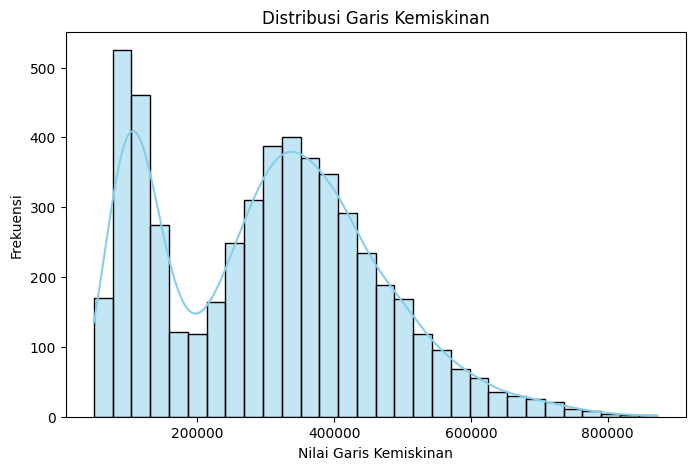

<ipython-input-4-e01cb66d8c69>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='provinsi', data=df, palette='viridis')


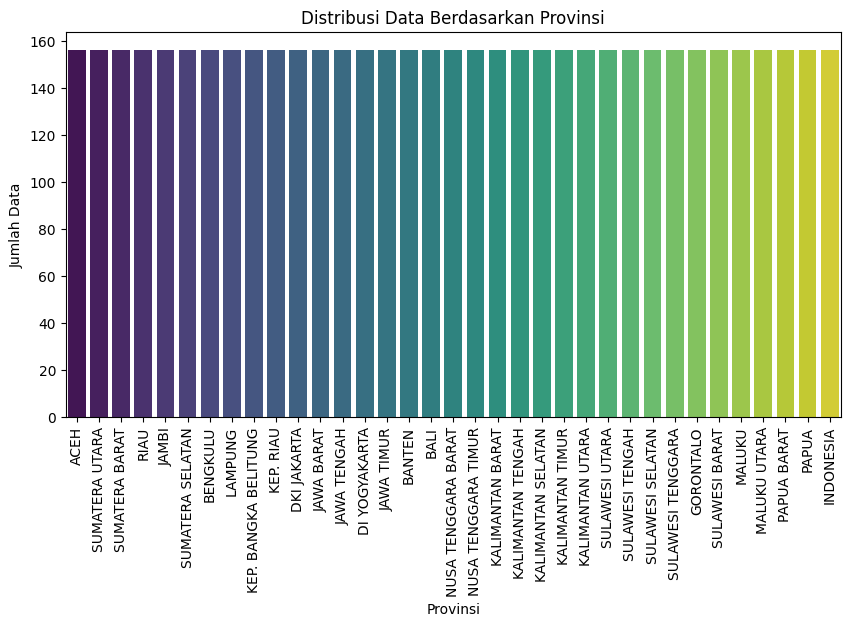

In [4]:
# Visualisasi distribusi nilai untuk fitur garis kemiskinan
plt.figure(figsize=(8,5))
sns.histplot(df['gk'], bins=30, kde=True, color='skyblue')
plt.title("Distribusi Garis Kemiskinan")
plt.xlabel("Nilai Garis Kemiskinan")
plt.ylabel("Frekuensi")
plt.show()

# Visualisasi distribusi data untuk kolom kategorikal (provinsi)
plt.figure(figsize=(10,5))
sns.countplot(x='provinsi', data=df, palette='viridis')
plt.title("Distribusi Data Berdasarkan Provinsi")
plt.xlabel("Provinsi")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=90)
plt.show()

Penjelasan:
- **Histogram**: Membantu mengidentifikasi apakah distribusi data normal, skewed, atau mengandung outlier.
- **Countplot**: Menunjukkan distribusi data kategorikal untuk mengetahui apakah terdapat kategori yang sangat dominan.

# **5. Data Preprocessing**

Pada tahap ini, saya membersihkan dan menyiapkan data agar siap untuk analisis clustering.

**1. Penanganan Missing Values**

Jika terdapat nilai kosong, gunakan imputasi dengan strategi yang sesuai (mean untuk numerik).

In [5]:
# Kolom 'gk' yang merupakan variabel numerik
imputer = SimpleImputer(strategy='mean')
df['gk'] = imputer.fit_transform(df[['gk']])

**2. Encoding Data Kategorikal**

Karena algoritma clustering (KMeans) membutuhkan data numerik, ubah data kategorikal menjadi numerik.

In [6]:
# Encoding kolom 'jenis' dan 'daerah' menggunakan LabelEncoder
label_encoder = LabelEncoder()
df['jenis_encoded'] = label_encoder.fit_transform(df['jenis'])
df['daerah_encoded'] = label_encoder.fit_transform(df['daerah'])

**3. Scaling Data Numerikal**

Scaling diperlukan agar perbedaan skala antar fitur tidak memengaruhi hasil clustering.

In [7]:
# Standarisasi kolom 'gk'
scaler = StandardScaler()
df['gk_scaled'] = scaler.fit_transform(df[['gk']])

**4. Pemilihan Fitur untuk Clustering**

Saya memilih fitur-fitur yang akan digunakan dalam clustering. Saya akan menggunakan:
- **gk_scaled** (hasil scaling dari garis kemiskinan)
- **jenis_encoded** (encoding dari jenis pengeluaran)
- **daerah_encoded** (encoding dari daerah)

In [8]:
# Menentukan fitur yang digunakan untuk clustering
features = ['gk_scaled', 'jenis_encoded', 'daerah_encoded']
X = df[features]

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

**Penentuan Jumlah Cluster Optimal**

Saya menggunakan metode Elbow dan Silhouette Score untuk menentukan jumlah cluster yang optimal.

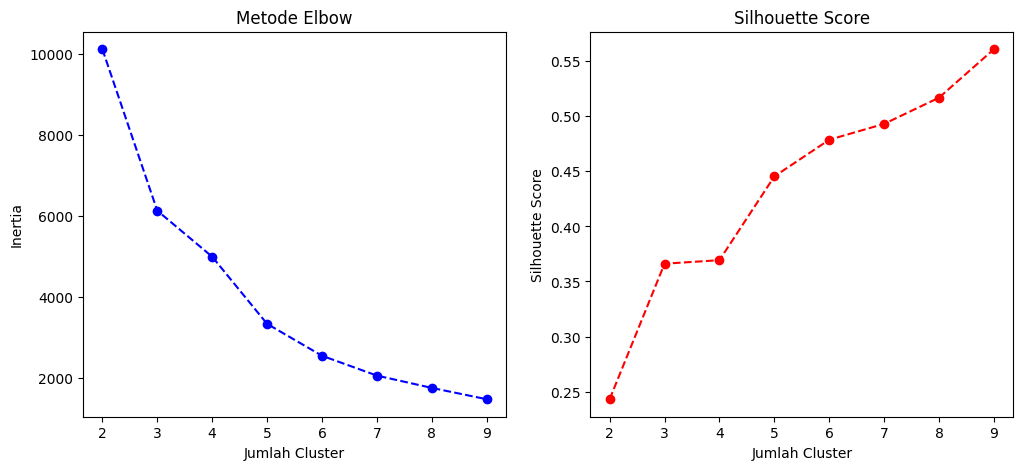

Jumlah cluster optimal berdasarkan Silhouette Score: 9


In [9]:
silhouette_scores = []
elbow_scores = []
K_range = range(2, 10)  # Mencoba jumlah cluster dari 2 - 9

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    silhouette_scores.append(score)
    elbow_scores.append(kmeans.inertia_)

# Visualisasi metode Elbow
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K_range, elbow_scores, marker='o', linestyle='--', color='b')
plt.xlabel("Jumlah Cluster")
plt.ylabel("Inertia")
plt.title("Metode Elbow")

# Visualisasi Silhouette Score
plt.subplot(1,2,2)
plt.plot(K_range, silhouette_scores, marker='o', linestyle='--', color='r')
plt.xlabel("Jumlah Cluster")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")
plt.show()

# Menentukan jumlah cluster optimal
optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print("Jumlah cluster optimal berdasarkan Silhouette Score:", optimal_k)

Penjelasan:
- **Elbow Method**: Menggunakan inertia sebagai ukuran varians dalam cluster. Titik “elbow” menunjukkan penurunan inertia yang mulai melambat.
- **Silhouette Score**: Mengukur seberapa baik data dikelompokkan; nilai di atas 0.55 (atau target yang lebih tinggi) menunjukkan kualitas cluster yang baik.

## **b. Evaluasi Model Clustering**

**Melatih Model KMeans dengan Jumlah Cluster Optimal**

Setelah menentukan jumlah cluster, saya melatih model KMeans dan simpan label cluster ke dalam dataset.

In [10]:
# Melatih model dengan jumlah cluster optimal
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Evaluasi akhir menggunakan Silhouette Score
final_score = silhouette_score(X, df['cluster'])
print("Silhouette Score akhir:", final_score)

Silhouette Score akhir: 0.5609656847756213


## **c. Feature Selection (Opsional)**

**Feature Selection**

Untuk meningkatkan performa clustering, saya melakukan feature selection. Saya dapat memilih fitur terbaik menggunakan metode SelectKBest. Berikut penerapannya:

**Catatan:**

**Karena data awal sudah berupa kombinasi fitur numerikal dan hasil encoding, penggunaan feature selection harus dilakukan dengan mempertimbangkan konteks. Jika terdapat banyak fitur, dapat menggunakan teknik ini untuk mengurangi dimensi dan membandingkan Silhouette Score sebelum dan sesudah pemilihan fitur.**

In [11]:
# Target 'gk_scaled' sebagai variabel dependen, pilih fitur yang berkorelasi tertinggi
selector = SelectKBest(score_func=f_classif, k=3)
X_new = selector.fit_transform(X, df['gk_scaled'])
selected_features = selector.get_support(indices=True)
print("Indeks fitur terpilih:", selected_features)

# Bandingkan Silhouette Score dengan fitur terpilih
kmeans_fs = KMeans(n_clusters=optimal_k, random_state=42)
clusters_fs = kmeans_fs.fit_predict(X_new)
silhouette_fs = silhouette_score(X_new, clusters_fs)
print("Silhouette Score setelah feature selection:", silhouette_fs)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


Indeks fitur terpilih: [0 1 2]
Silhouette Score setelah feature selection: 0.5609656847756213


Penjelasan Feature Selection:
- **SelectKBest**: Digunakan untuk memilih sejumlah fitur terbaik berdasarkan nilai statistik.
- **Komparasi**: Bandingkan Silhouette Score dengan data asli dan data setelah feature selection untuk menilai apakah proses tersebut memberikan peningkatan kualitas cluster.

## **d. Visualisasi Hasil Clustering**

**Visualisasi Hasil Clustering**

Untuk visualisasi, saya mereduksi dimensi menggunakan PCA agar hasil clustering dapat ditampilkan dalam 2 dimensi.

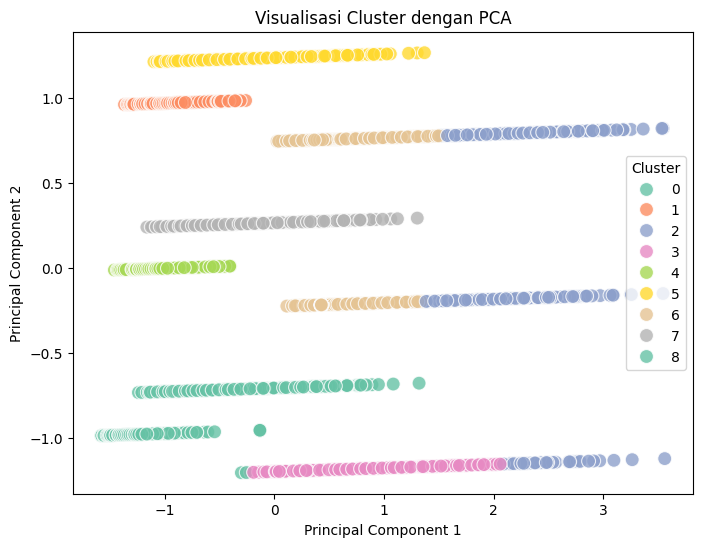

In [12]:
# Reduksi dimensi menggunakan PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X)
df['PC1'] = components[:, 0]
df['PC2'] = components[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df, palette='Set2', s=100, alpha=0.8)
plt.title("Visualisasi Cluster dengan PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.show()

Penjelasan:
- **PCA**: Mengurangi dimensi data agar dapat divisualisasikan dalam plot 2D.
- **Scatterplot**: Menampilkan distribusi cluster dan memudahkan interpretasi visual mengenai pemisahan antar cluster.

## **e. Analisis dan Interpretasi Hasil Cluster**

Setelah clustering selesai, langkah selanjutnya adalah melakukan interpretasi mendalam terhadap masing-masing cluster.

**1. Inverse Transformasi Data:**

Jika data numerikal telah diskalakan, lakukan inverse transform untuk mendapatkan nilai asli.

In [13]:
# Mengembalikan skala asli untuk fitur 'gk'
df['gk_original'] = scaler.inverse_transform(df[['gk_scaled']])

**2. Agregasi Data Berdasarkan Cluster**

Lakukan agregasi untuk mengetahui statistik tiap cluster, seperti nilai minimum, maksimum, dan rata-rata untuk fitur numerikal serta modus untuk fitur kategorikal.

In [14]:
# Agregasi statistik untuk fitur numerikal: contoh pada 'gk_original'
cluster_agg_num = df.groupby('cluster')['gk_original'].agg(['min', 'max', 'mean']).reset_index()
print(cluster_agg_num)

# Fungsi untuk mendapatkan modus pada fitur kategorikal
def get_mode(series):
    return series.mode()[0]

# Agregasi untuk fitur kategorikal: 'jenis'
cluster_agg_cat = df.groupby('cluster')['jenis'].agg(get_mode).reset_index()
print(cluster_agg_cat)

   cluster       min       max           mean
0        0  190563.0  641806.0  334159.893987
1        1   52529.0  247232.0  133580.508929
2        2  469596.0  872843.0  580160.588119
3        3  207023.0  609733.0  390819.612526
4        4   53095.0  239224.0  117604.692857
5        5  181842.0  616790.0  338483.560714
6        6  215910.0  477801.0  365263.065074
7        7  187304.0  622068.0  338008.525000
8        8   48561.0  231037.0  101884.600733
   cluster       jenis
0        0     MAKANAN
1        1  NONMAKANAN
2        2       TOTAL
3        3       TOTAL
4        4  NONMAKANAN
5        5     MAKANAN
6        6       TOTAL
7        7     MAKANAN
8        8  NONMAKANAN


Interpretasi:

Cluster 0
- Garis Kemiskinan: Min 190.563 | Max 641.806 | Rata-rata 334.159
- Pengeluaran Dominan: Makanan
- Analisis: Wilayah ini memiliki tingkat kemiskinan menengah dengan pengeluaran utama untuk makanan, menandakan kebutuhan pangan sebagai prioritas utama.

Cluster 1
- Garis Kemiskinan: Min 52.529 | Max 247.232 | Rata-rata 133.581
- Pengeluaran Dominan: Nonmakanan
- Analisis: Wilayah dengan garis kemiskinan rendah dan pengeluaran lebih banyak untuk kebutuhan selain makanan, mungkin biaya hidup lebih rendah.

Cluster 2
- Garis Kemiskinan: Min 469.596 | Max 872.843 | Rata-rata 580.161
- Pengeluaran Dominan: Total
- Analisis: Wilayah dengan kemiskinan tertinggi dan pengeluaran menyeluruh, menunjukkan daya beli lebih besar atau biaya hidup tinggi.

Cluster 3
- Garis Kemiskinan: Min 207.023 | Max 609.733 | Rata-rata 390.820
- Pengeluaran Dominan: Total
- Analisis: Kemiskinan cukup tinggi dengan pola pengeluaran seimbang antara makanan dan nonmakanan.

Cluster 4
- Garis Kemiskinan: Min 53.095 | Max 239.224 | Rata-rata 117.605
- Pengeluaran Dominan: Nonmakanan
- Analisis: Wilayah dengan kemiskinan rendah dan pengeluaran lebih banyak ke kebutuhan selain makanan, mungkin daerah dengan biaya hidup murah.

- Cluster 5
- Garis Kemiskinan: Min 181.842 | Max 616.790 | Rata-rata 338.484
- Pengeluaran Dominan: Makanan
- Analisis: Mirip dengan Cluster 0, wilayah ini lebih fokus pada pemenuhan kebutuhan pangan.

Cluster 6
- Garis Kemiskinan: Min 215.910 | Max 477.801 | Rata-rata 365.263
- Pengeluaran Dominan: Total
- Analisis: Garis kemiskinan menengah ke atas, dengan pola pengeluaran yang lebih seimbang antara kebutuhan pokok dan lainnya.

- Cluster 7
- Garis Kemiskinan: Min 187.304 | Max 622.068 | Rata-rata 338.009
- Pengeluaran Dominan: Makanan
- Analisis: Sama seperti Cluster 0 dan 5, wilayah ini berfokus pada kebutuhan pangan.

Cluster 8
- Garis Kemiskinan: Min 48.561 | Max 231.037 | Rata-rata 101.885
- Pengeluaran Dominan: Nonmakanan
- Analisis: Wilayah dengan tingkat kemiskinan paling rendah, dengan pengeluaran lebih besar ke nonmakanan meskipun daya beli tetap rendah.

Kesimpulan:
- Cluster dengan kemiskinan tinggi (2, 3) cenderung memiliki pengeluaran total yang besar, menandakan biaya hidup lebih tinggi.
- Cluster dengan dominasi makanan (0, 5, 7) menunjukkan wilayah di mana pangan menjadi prioritas utama.
- Cluster dengan dominasi nonmakanan (1, 4, 8) bisa jadi memiliki biaya hidup lebih rendah atau pola konsumsi yang berbeda.
- Perbedaan antar cluster bisa dipengaruhi oleh ekonomi wilayah, biaya hidup, dan pola pengeluaran masyarakat.

# **7. Mengeksport Data**

Setelah proses clustering dan interpretasi selesai, simpan dataset yang telah dilengkapi label cluster agar nantinya dapat digunakan pada tahap klasifikasi.

In [16]:
df.to_csv("gariskemiskinan_with_cluster.csv", index=False)
print("Dataset dengan label cluster telah disimpan.")

Dataset dengan label cluster telah disimpan.
